# Diabetes Classification Project

For our second data science project, we have chosen a very relevant and important subject: diabetes. Diabetes is a growing global phenomenon, and it has the potential to be as dangerous as it is prevalent. In fact, it is a leading cause of death worldwide, and mismanaged diabetes is a leading cause to blindness, amputations, kidney failure, heart disease, and other tragic chronic illnesses/disabilities. Though the manifestation of diabetes has a strong genetic factor, Type 2 diabetes (the type of diabetes that develops at a later stage of life) can be prevented, and if it occurs, can be well-managed.

Therefore, knowing the factors that are correlated with Diabetes is very helpful in realizing that one may be in a risk group and should take precautionary measures to prevent Diabetes; and thus, this classification task serves us in both data science knowledge and very important health knowledge. For this task, our target will be the existence of Diabetes in an instance (the 'Outcome' column), and the classification will be based upon the other features of each instance.

# Procedure:

1. Cleaning the Data and Feature Engineering
2. Visualizing/Getting to Know Our Data
3. Testing Different Models
4. Fine-Tuning our Models
5. Finally: Testing our Best Model

# Cleaning the Data & Feature Engineering

In [1]:
# First, let's import the necessary tools to proceed and load our datatset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


from sklearn.dummy import DummyClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [2]:
# Let's take a look at our data, shall we?

df = pd.read_csv('diabetes.csv')

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# let's look into the details of each column, to look for null-values and to see the type of type per feature.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# let's take a deeper look at the blood pressure column

df['BloodPressure'].min()

0

Here, we noticed that we have an impossible minimum value: 0. It is clear that every 0 value should be treated as a null instance. We decided to solve this problem by filling all 0 values with the mean Blood Pressure.

In [5]:
blood_pressure_exist = df[df['BloodPressure']!=0]
blood_pressure_exist =blood_pressure_exist['BloodPressure']
df['BloodPressure']=df['BloodPressure'].apply(lambda x:int(blood_pressure_exist.mean()) if x==0 else x)
df['BloodPressure']

0      72
1      66
2      64
3      66
4      40
       ..
763    76
764    70
765    72
766    60
767    70
Name: BloodPressure, Length: 768, dtype: int64

Furthermore, we decided to feature engineer another feature from the Blood Pressure feature: we will create a column that categorizes an instance as high blood pressure or not, as diabetes and high blood pressure often occur together and the existence of one of these conditions can exacerbate the other (2 in 3 diabetic people have high blood pressure). 


Diastolic pressure above 80 is considered high blood pressure, and therefore, for every instance that has an 80 or above blood pressure, we will categorize as having high blood pressure.

In [6]:
df['High_BloodPressure']=df['BloodPressure'].apply(lambda x:1 if x>=80 else 0)
df['High_BloodPressure'].value_counts()

0    563
1    205
Name: High_BloodPressure, dtype: int64

We have noticed that yet another feature of ours has an impossible value of 0: BMI, and therefore we will treat a BMI of 0 as a null value. We decided to solve this problem by filling all 0 values with the median BMI.

In [7]:
bmi_noNull=df[df['BMI']!=0]
bmi_noNull['BMI'].median()
df['BMI']=df['BMI'].apply(lambda x:bmi_noNull['BMI'].median() if x==0 else x)
df['BMI']

0      33.6
1      26.6
2      23.3
3      28.1
4      43.1
       ... 
763    32.9
764    36.8
765    26.2
766    30.1
767    30.4
Name: BMI, Length: 768, dtype: float64

Furthermore, we have decided to feature engineer another feature from our BMI feature: a feature which categorized Weight ('Weight'): 'underweight' (BMI of 18.5 or less), 'healthy weight' (BMI 18 to 30, not including 30) and 'obese' (a BMI of 30 and above).
This feature could be of great importance, as obesity accounts for 80-85% of the risk of developing Type 2 diabetes; whereas Healthy Weight and Underweight may help distinguish the non-diabetic people apart from the diabetic people.

In [8]:
def find_weight(position):
    if position<18.5:
        return 'UnderWeight'
    elif position>=18.5 and position<30:
        return 'Healthy'
    else :
        return 'Obese'
    
df['Weight']=df['BMI'].apply(find_weight)
df['Weight'].value_counts()

Obese          483
Healthy        281
UnderWeight      4
Name: Weight, dtype: int64

We have noticed that once again we have another feature which has an impossible value of 0: Glucose levels. We decided to solve this problem by filling all 0 values with the mean Glucose value.

In [9]:
glucose_no_zero=df[df['Glucose']!=0]

df['Glucose']=df['Glucose'].apply(lambda x:int(glucose_no_zero['Glucose'].mean()) if x==0 else x)

Furthermore, we have decided to feature engineer a feature through the Glucose feature: Glucose Level. Normal blood glucose level (tested while fasting) for non-diabetics is between 3.9 and 7.1 mmol/L (70 and 130 mg/dL), and therefore, we will consider anything below 70 as low and anything above 130 as high. There is great significance to this feature as Glucose Level is the diagnostic measure of diabetes; high glucose levels is a sign of diabetes.

In [10]:
def define_glucose_level(position):
    if position<70:
        return 'low_glucose_levels'
    elif position>=130:
        return 'high_glucose_levels'
    else:
        return 'normal_glucose_levels'
    
df['Glucose_Level']=df['Glucose'].apply(define_glucose_level)
df['Glucose_Level'].value_counts()

normal_glucose_levels    499
high_glucose_levels      258
low_glucose_levels        11
Name: Glucose_Level, dtype: int64

Yet another feature we have decided to engineer is a feature that accounts for elderly instances; as Type 2 diabetes has a later onset, and is quite common in elderly people. We will set anyone who is 65 years old or older as elderly.

In [11]:
df['Elderly']=df['Age'].apply(lambda x:1 if x>=65 else 0)
df['Elderly'].value_counts()

0    752
1     16
Name: Elderly, dtype: int64

We have noticed another feature in which has an impossible value of 0: Skin Thicnkess. 
This box plot of the distribution reveals that there is a great amount of instances in which Skin Thickness was set at this null 0 value:

<AxesSubplot:>

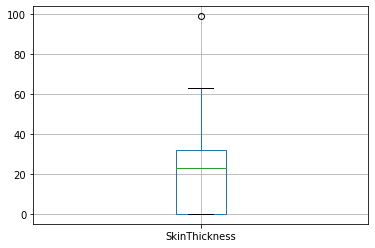

In [12]:
df.boxplot(column=['SkinThickness'])

Therefore, to counteract this, we will set the null 0 values with the most frequently occuring value (other than 0), and that would be 32.

In [13]:
skin_thickness_without=df[df['SkinThickness']!=0]

print(skin_thickness_without['SkinThickness'].mode())

df['SkinThickness']=df['SkinThickness'].apply(lambda x:32 if x==0 else x)
df['SkinThickness']

0    32
dtype: int64


0      35
1      29
2      32
3      23
4      35
       ..
763    48
764    27
765    23
766    32
767    31
Name: SkinThickness, Length: 768, dtype: int64

We have decided to engineer a feature from the SkinThickness feature: SkinThickness levels. We have divided it into 10 levels.
This feature is indeed relevant as high skin thickness is greatly related to the existence of diabetes.

In [14]:
def thickness_level(position):
    if position<=10:
        return 1
    elif position<=20:
        return 2
    elif position<=30:
        return 3
    elif position<=40:
        return 4
    elif position<=50:
        return 5
    elif position<=60:
        return 6
    elif position<=70:
        return 7
    elif position<=80:
        return 8
    elif position<=90:
        return 9
    else:
        return 10
    
df['Thickness_level']=df['SkinThickness'].apply(thickness_level)
df['Thickness_level'].value_counts()

4     391
3     179
2     115
5      65
1       9
6       7
7       1
10      1
Name: Thickness_level, dtype: int64

Finally, we have noticed that Insulin, too, has impossible values of 0. Let's look at its distribution:

<AxesSubplot:>

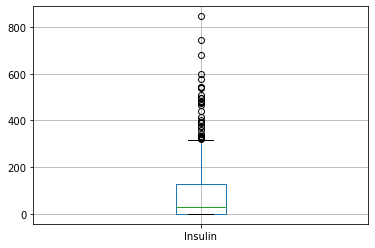

In [15]:
df.boxplot(column=['Insulin'])

Due to the high amount of outliers, we have decided to solve the issue of the null 0 values by filling those values with the median Insulin value (as opposed to the mean) to avoid getting a skewed value.

In [16]:
insulin_without_zero=df[df['Insulin']!=0]
insulin_without_zero['Insulin'].median()
df['Insulin']=df['Insulin'].apply(lambda x:insulin_without_zero['Insulin'].median() if x==0 else x)
df['Insulin']

0      125.0
1      125.0
2      125.0
3       94.0
4      168.0
       ...  
763    180.0
764    125.0
765    112.0
766    125.0
767    125.0
Name: Insulin, Length: 768, dtype: float64

In [17]:
# our final cleaned dataset

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,High_BloodPressure,Weight,Glucose_Level,Elderly,Thickness_level
0,6,148,72,35,125.0,33.6,0.627,50,1,0,Obese,high_glucose_levels,0,4
1,1,85,66,29,125.0,26.6,0.351,31,0,0,Healthy,normal_glucose_levels,0,3
2,8,183,64,32,125.0,23.3,0.672,32,1,0,Healthy,high_glucose_levels,0,4
3,1,89,66,23,94.0,28.1,0.167,21,0,0,Healthy,normal_glucose_levels,0,3
4,0,137,40,35,168.0,43.1,2.288,33,1,0,Obese,high_glucose_levels,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.0,32.9,0.171,63,0,0,Obese,normal_glucose_levels,0,5
764,2,122,70,27,125.0,36.8,0.340,27,0,0,Obese,normal_glucose_levels,0,3
765,5,121,72,23,112.0,26.2,0.245,30,0,0,Healthy,normal_glucose_levels,0,3
766,1,126,60,32,125.0,30.1,0.349,47,1,0,Obese,normal_glucose_levels,0,4


We saved our clean dataset into this file:

df.to_csv('Cleaned_Diabetes.csv')

# Visualizing / Getting to Know Our Data

How can we secure that there is no data leakage? So as to ensure that our model's performance is reliable, there is a need to prevent any data leakage, or else we will not receive an accurate perception of our model's capabilities; it may perform well on our test, but with a different set, be a lot less successful. To prevent data leakage, we will separate our data into test and train sets, and we will only use the training set for our visualizations and model testing. The test set will be used strictly for our final test.

So first and foremost, we split our data into train and test sets, so as to not leak the test set during visualization.

In [18]:
df2=pd.read_csv('Cleaned_Diabetes.csv',index_col=0)

In [19]:
# splitting the data into train & test with random state of 25

train_set, test_set = train_test_split(df, test_size=0.2, random_state=25)

And then we saved each set to a csv like so:

train_set.to_csv('train_set_diabetes.csv')

test_set.to_csv('test_set_diabetes.csv')

Now tha we split the model, we can begin to get to know our data a bit using our train set via visualizations. We will first loud the necessary datasets.

In [3]:
df=pd.read_csv('train_set_diabetes.csv',index_col=0)
df2=pd.read_csv('Cleaned_Diabetes.csv',index_col=0)

As part of our visualization process, because the 'Outcome' column is our target, we have decided to separate the dataset into two separate datatsets for some visualizations: a dataset for diabetic (1) instances and a dataset for non-diabetic (0) instances.

In [4]:
df_true=df[df['Outcome']==1]
df_false=df[df['Outcome']==0]

Now we will use these separate datasets to see the distributions of several features across diabetic instances vs non-diabetic instances.

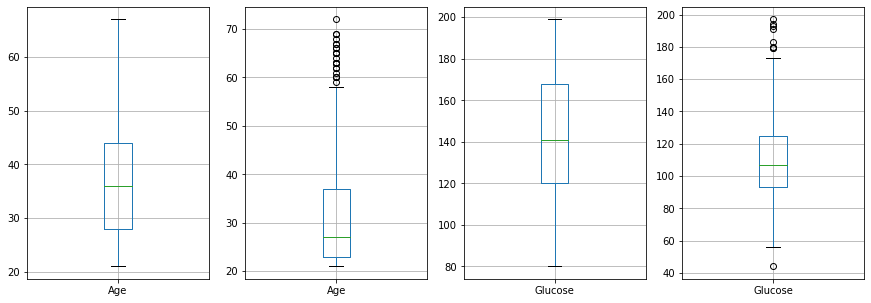

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5)) 


df_true.boxplot(column=['Age'],ax=axes[0])
df_false.boxplot(column=['Age'],ax=axes[1])
df_true.boxplot(column=['Glucose'],ax=axes[2])
df_false.boxplot(column=['Glucose'],ax=axes[3])

As we can see, most diabetic instances fall between the ages of 28-43, with a median of around 35, and our upper fence reaches a pretty old age. On the other hand, most non-diabetic instances fall between the ages 24 to 38, with a median of around 27 (notice that the median is slightly younger than the lower quartile of the diabetic instances) and additionally, all instances above the age of 58 are outliers. It is very clear that the diabetic instances tend to be 'older'; and if an instance is above age 58, it is most likely that instance is that of a diabetic individual. 

As for the distribution of Glucose, the range is clearly wider in diabetic patients, with a clear tendency to be a lot higher: specifically, the interquartile range of diabetic instances falls under glucose values of 120 to 170; the glucose value can reach as high as almost 200, and there is no value below 80. Meanwhile the interquartile range of non-diabetic isntances falls under 95 to 125; and anything above 175 is an outlier value, and the glucose values can be as low as 45 (though that is an outlier value). This hints to us that glucose values above a certain threshold are most likely to be diabetic instances while glucose levels below a certain threshold are most likely to be non-diabetic instances.

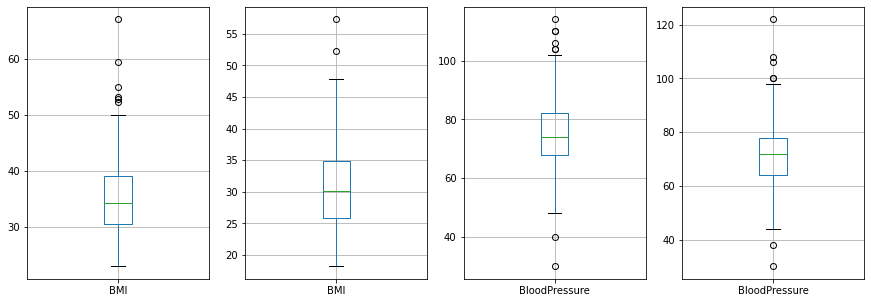

In [9]:

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5)) 

df_true.boxplot(column=['BMI'],ax=axes[0])
df_false.boxplot(column=['BMI'],ax=axes[1])
df_true.boxplot(column=['BloodPressure'],ax=axes[2])
df_false.boxplot(column=['BloodPressure'],ax=axes[3])

As we can see, the interquartile range of BMI's for diabetic instances is from around 30 to 40; it is quite interesting as an above 30 BMI is obese; this is showing a clear link between the occurance of diabetes and obesity. Meanwhile, the interquartile range of BMI's for nondiabetic instances is less by around 5 points, which is quite significant. Indeed, BMI's tend to be higher in diabetic instances.

As for blood pressure, it appears that the distribution is actually quite similar for both diabetic and nondiabetic instances. Perhaps blood pressure is not a strong feature to differentiate between the two.

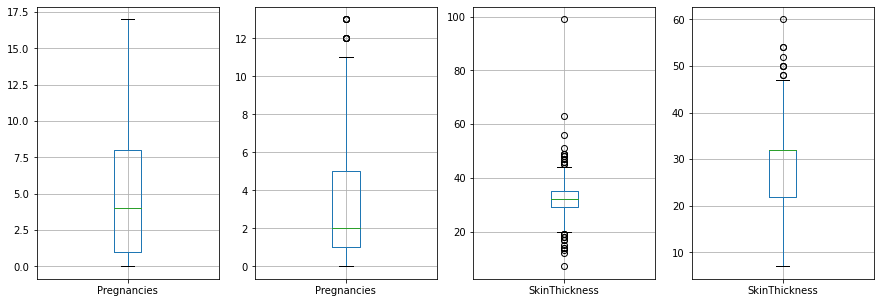

In [10]:


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5)) 


df_true.boxplot(column=['Pregnancies'],ax=axes[0])
df_false.boxplot(column=['Pregnancies'],ax=axes[1])
df_true.boxplot(column=['SkinThickness'],ax=axes[2])
df_false.boxplot(column=['SkinThickness'],ax=axes[3])

As we can see, for instances of diabetes, the interquartile range of pregnancies is from around 1 to 8, the upper fence as high as 17 pregnancies! Meanwhile, the interquartile range of pregnancies in nondiabetic instances is 1 to 5, and above 11 pregnancies is already an outlier; indeed, diabetic instances tend to have more pregnancies.

As for skin thickness, there is a great concentration in the diabetic instances in the values of 20 to 45: anything above or below that range is an outlier. Meanwhile, the skinthickness is a lot less concentrated in nondiabetic instances: the range is from around 5 to 45. Indeed, the outlier values of the skin thickness for diabetic instances may be used to distinguish it from nondiabetic instances.

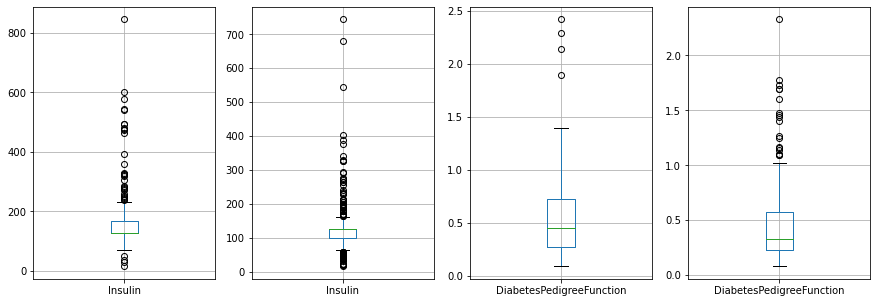

In [11]:


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5)) 


df_true.boxplot(column=['Insulin'],ax=axes[0])
df_false.boxplot(column=['Insulin'],ax=axes[1])
df_true.boxplot(column=['DiabetesPedigreeFunction'],ax=axes[2])
df_false.boxplot(column=['DiabetesPedigreeFunction'],ax=axes[3])

As we can see, in instances of diabetes there tend to be higher levels of insulin in the distribution. Our theory is that this may be due to insulin given to sufferers of diabetes, and it may therefore increase the levels beyond the levels creates naturally by nondiabetic people..

As for Diabetes Pedigree Function, we see that higher values are likely to belong to diabetic instances as well.

Indeed, these box plots have given us very valuable information about some of the differences in diabetic and nondiabetic instances. Next, we will look at some pie charts.

Text(0.5, 1.0, 'Elderly diabetics:')

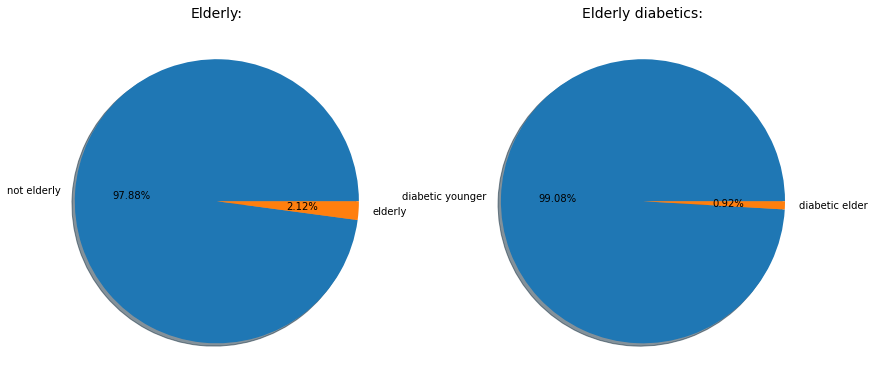

In [12]:
#as we can see making this column wasnt so helpful
fig, ax = plt.subplots(1,2, figsize = (14,14))
(ax1, ax2) = ax

labels =['not elderly', 'elderly']
values = df['Elderly'].value_counts().tolist()
ax1.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True)
ax1.set_title("Elderly:", fontdict={'fontsize': 14})

labels2 =['diabetic younger', 'diabetic elder']
values2 = df_true['Elderly'].value_counts().tolist()
ax2.pie(x=values2, labels=labels2, autopct="%1.2f%%", shadow=True)
ax2.set_title("Elderly diabetics:", fontdict={'fontsize': 14})

These pie charts aim to show the significance, or rather lack thereof, of our new feature, The Elderly column. We tried this feature for logical reasons, but it appears that due to our dataset's distribution in ages, the amount of elderly people is insignificant. Only 2.12% of the dataset are elderly folks, and of all diabetic instances, only 0.92% are elderly. Therefore, these pie charts revealed that this can be a feature we can discard when we go into feature selection.

Text(0.5, 1.0, 'Glucose Level diabetics:')

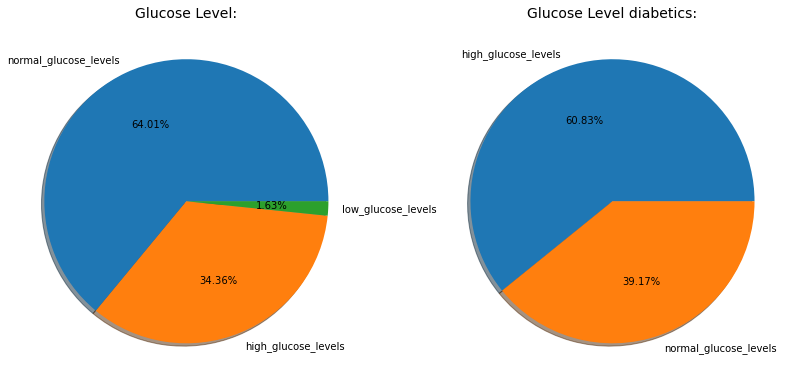

In [13]:
fig, ax = plt.subplots(1,2, figsize = (14,14))
(ax1, ax2) = ax

labels = df['Glucose_Level'].value_counts().index.tolist()
values = df['Glucose_Level'].value_counts().tolist()
ax1.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True)
ax1.set_title("Glucose Level:", fontdict={'fontsize': 14})

labels2 = df_true['Glucose_Level'].value_counts().index.tolist()
values2 = df_true['Glucose_Level'].value_counts().tolist()
ax2.pie(x=values2, labels=labels2, autopct="%1.2f%%", shadow=True)
ax2.set_title("Glucose Level diabetics:", fontdict={'fontsize': 14})

On the other hand, here are is a significant feature: glucose levels! The first pie chart shows the percentages in the difference categories of glucose levels for the entire dataset; clearly, the majority falls within the normal range (64%), while only 34% have high glucose levels. On the other hand, for diabetic instances, that is the exact opposite: most diabetics have high glucose levels (60%) and only 39% have normal glucose levels; meanwhile, there is no diabetic instance with low glucose levels! Clearly, high glucose levels is very related to diabetes.

Text(0.5, 1.0, 'Thickness level diabetics:')

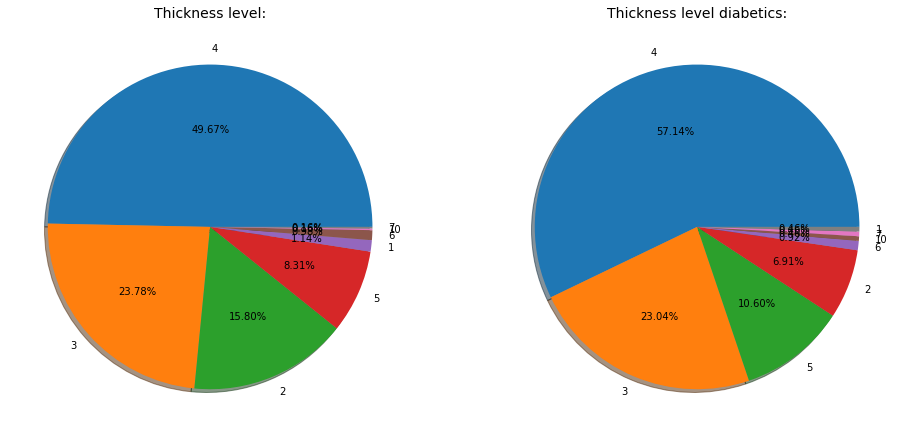

In [14]:
fig, ax = plt.subplots(1,2, figsize = (16,16))
(ax1, ax2) = ax

labels = df['Thickness_level'].value_counts().index.tolist()
values = df['Thickness_level'].value_counts().tolist()
ax1.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True)
ax1.set_title("Thickness level:", fontdict={'fontsize': 14})

labels2 = df_true['Thickness_level'].value_counts().index.tolist()
values2 = df_true['Thickness_level'].value_counts().tolist()
ax2.pie(x=values2, labels=labels2, autopct="%1.2f%%", shadow=True)
ax2.set_title("Thickness level diabetics:", fontdict={'fontsize': 14})

These pie charts check if there are any major differences between skin thickness levels in diabetics and in nondiabetics. The levels are not exactly in the same percentages but they are pretty similar: most cases, regardless of what case, have a skin thickness level of 4, and runner up is 3. For diabetic instances, 5 is more likely than 2, while in the other case, 2 is more likely than 5; but that is the only major difference. 
Therefore, skin thickness may not be a significant feature to distinguish between diabetic and nondiabetic instances.

Text(0.5, 1.0, 'High BloodPressure diabetics:')

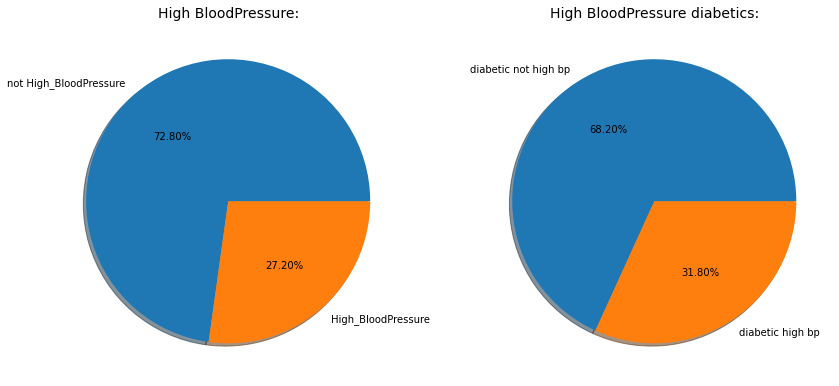

In [15]:
fig, ax = plt.subplots(1,2, figsize = (14,14))
(ax1, ax2) = ax

labels =['not High_BloodPressure', 'High_BloodPressure']
values = df['High_BloodPressure'].value_counts().tolist()
ax1.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True)
ax1.set_title("High BloodPressure:", fontdict={'fontsize': 14})

labels2 =['diabetic not high bp', 'diabetic high bp']
values2 = df_true['High_BloodPressure'].value_counts().tolist()
ax2.pie(x=values2, labels=labels2, autopct="%1.2f%%", shadow=True)
ax2.set_title("High BloodPressure diabetics:", fontdict={'fontsize': 14})

These pie charts aim to see the difference in percentages of high blood pressure in diabetic instances and the others. These pie charts are very similar in their distribution, with diabetic instances having a slightly bigger percentage of high blood pressure occuring. We believe this may be due to the fact that ther are not that many instances of high blood pressure occuring in this dataset; but regardless, the results are not contrasting enough. Therefore, this is yet another feature that may not play a significant role in distinguishing between diabetic and nondiabetic instances.

Now let's take a look at some correlations! 

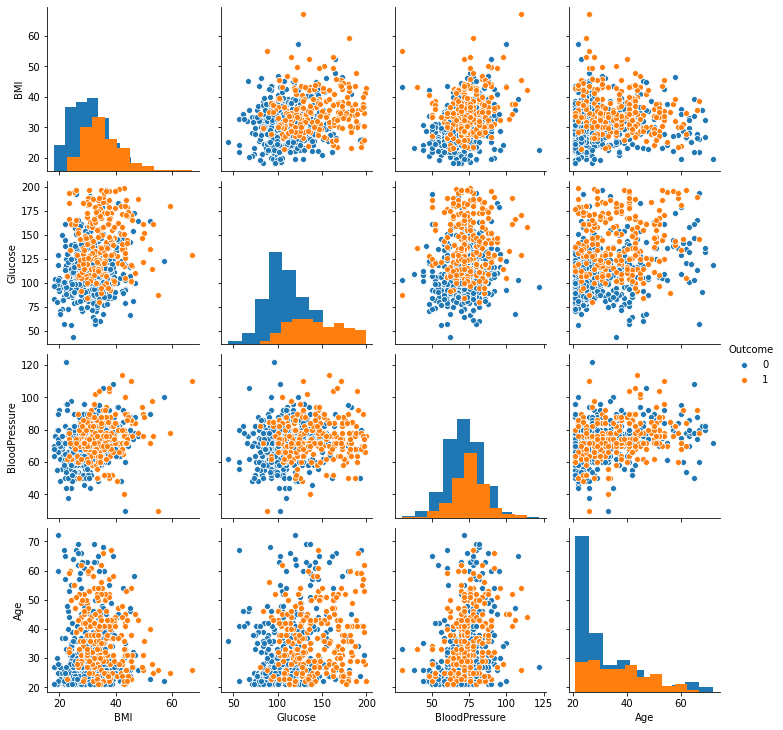

In [16]:
sns.pairplot(df[['Outcome','BMI','Glucose','BloodPressure','Age']],hue='Outcome', diag_kind="hist")

BMI CORRELATIONS: It appears that for diabetic instances, there are also more instances of higher BMI's; the BMI does not determine the glucose value in the blood; for a certain high level of blood pressure, it is reached by mostly higher BMI's; the younger ages tend to have a greater range in BMI's; the rest have a concnetrated range that does not change.


GLUCOSE CORRELATIONS: It appears that for a certain value of glucose values in the blood, all of the cases are that of diabetes; it appears that there is no correlation between glucose and blood pressure, nor in glucose and age.

BLOOD PRESSURE CORRELATIONS: It appears that as BMI increases, the blood pressure increases; both nondiabetic and diabetic instances have similar distributions in blood pressure, but diabetic's are slightly higher; the younger ages have a more diverse range in blood pressure; later ages are more concentrated on a higher level of blood pressure.

AGE CORRELATIONS: the nondiabetic and diabetic instances have a similar range of ages, but there are a lot less frequent 'young' people that are diabetic.

To see some more about correlations, we have decided to see some graphs of the numerical features for specifically the diabetic instances.

Text(0.5, 1.0, 'Diabetes Patient')

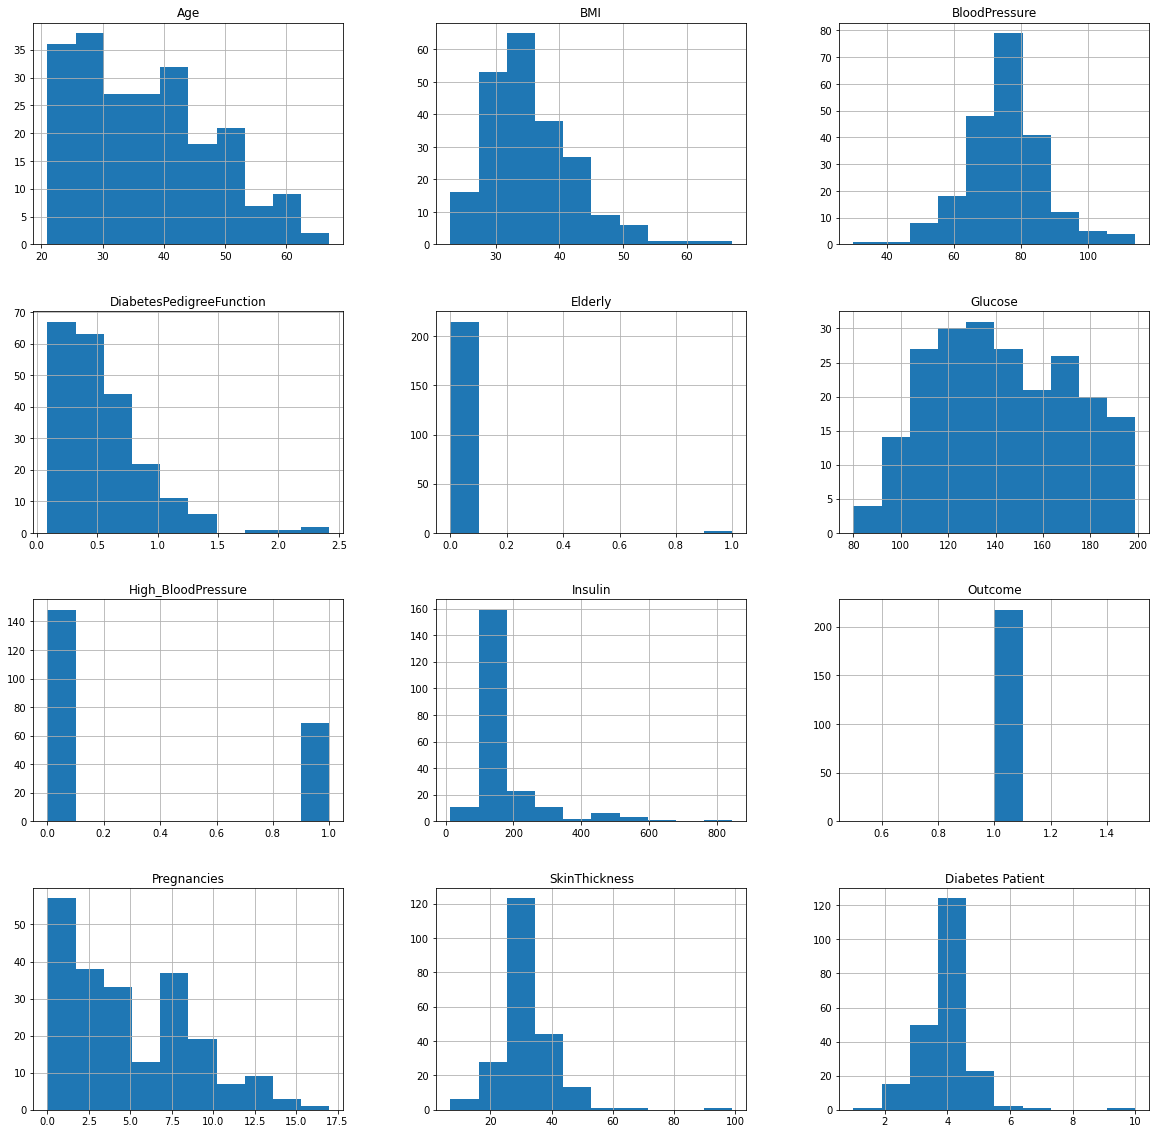

In [17]:
p = df[df['Outcome']==1].hist(figsize = (20,20))
plt.title('Diabetes Patient')

# Testing Different Models

Before testing the models, we will prepare our dataset. We have decided to start off with all the features in the dataset, and use feature selection to optimize our models later on if it deems helpful.

The step in preparation that is important to us at this stage is to handle our categorical features. We will create dummy variables via the get_dummies function: this will create boolean features (values 0 or 1) per category in the categorical features.

Now, first and foremost, we will split our dataset into train and test.

In [20]:
df=pd.read_csv('Cleaned_Diabetes.csv',index_col=0)

In [21]:
# set aside numerical comlumns, because they may be of later use

numerical_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age',
       'High_BloodPressure',
       'Thickness_level']

# use the 'get dummies' function

df_n = pd.get_dummies(df)

X = df_n.drop(['Outcome'], axis=1)
y = df_n['Outcome'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,High_BloodPressure,Elderly,Thickness_level,Weight_Healthy,Weight_Obese,Weight_UnderWeight,Glucose_Level_high_glucose_levels,Glucose_Level_low_glucose_levels,Glucose_Level_normal_glucose_levels
118,4,97,60,23,125.0,28.2,0.443,22,0,0,3,1,0,0,0,0,1
336,0,117,72,32,125.0,33.8,0.932,44,0,0,4,0,1,0,0,0,1
374,2,122,52,43,158.0,36.2,0.816,28,0,0,5,0,1,0,0,0,1
518,13,76,60,32,125.0,32.8,0.180,41,0,0,4,0,1,0,0,0,1
716,3,173,78,39,185.0,33.8,0.970,31,0,0,4,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,3,182,74,32,125.0,30.5,0.345,29,0,0,4,0,1,0,1,0,0
143,10,108,66,32,125.0,32.4,0.272,42,0,0,4,0,1,0,0,0,1
474,4,114,64,32,125.0,28.9,0.126,24,0,0,4,1,0,0,0,0,1
318,3,115,66,39,140.0,38.1,0.150,28,0,0,4,0,1,0,0,0,1


Now, due to the nature of the testing process, we will need to create another train-test split with the training set.

In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train, test_size=0.2, random_state=25)

Now we will create another version of the dataset, this time Standarized, and we will see if the scaled version is improving our models.

In [23]:
standard = StandardScaler()

X_test_stand = X_test.copy()
X_train_stand = X_train.copy()
y_train_stand = y_train.copy()
y_test_stand = y_test.copy()

X_test2_stand = X_test2.copy()
X_train2_stand = X_train2.copy()
y_train2_stand = y_train2.copy()
y_test2_stand = y_test2.copy()


X_train_stand[numerical_columns] = standard.fit_transform(X_train_stand[numerical_columns])
X_test_stand[numerical_columns] = standard.transform(X_test_stand[numerical_columns])

X_train2_stand[numerical_columns] = standard.fit_transform(X_train2_stand[numerical_columns])
X_test2_stand[numerical_columns] = standard.transform(X_test2_stand[numerical_columns])

Now that we have prepared several versions of our dataframe, we will create a dummy model by which to establish a standard for how our models are doing. Indeed, a dummy model refers to a baseline model creates for the purpose of comparison with more complex models. To elaborate, the role of the dummy model is to give us an idea of what 'score' values of a poorly-made model would be; if our models align with these scores, or are worse than these scores, they are doing very poorly.

We will be using a Dummy Regressor model with the default settings.

It is important to note that we will also be using the following metric tools for our testing:

- Recall/Sensitivity: this metric tool is the True Positive Rate, which measures the rate of positive instances that are correctly detected by the classifier. In our project, a high recall means that if someone is diabetic, most chances they will be labeled as diabetic in our model. We place a high importance on this metric tool because our highest priority is to classify diabetic people as diabetic so they may receieve the proper treatment.


- AUC of ROC: This score is the area under the curve of the Receiver Operating Characteristic graph, which plots the True Positive Rate against the False Positive Rate. We place a high importance on this metric tool because it gives us another angle on our classification: we may have a reall high recall score but also have a very high false positive rate, which means that our model very easily classifies people as diabetic, but is not effective at accurately classification; thus, the AUC of the ROC curve can tell us whether our model is effective or not.


- Precision: this metric tool measures the accuracy of the positive predictions. In our project, a high precision means that most of the time when someone is said to have diabetes, they really have diabetes that means that we are lowering the chance that someone would be falsely labeled as diabetic when they're not. While we do not wish to falsely classify someone as diabetic, we found the recall to be more important for our task, and we expect that our precision will decrease as our recall increases. 


- F-Score: this metric tool considers both the precision and recall score. We will be using it to see that we are on track in both parameters. Again, this will not be as important of a tool as would the Recall and ROC but we will still want to ensure that we have a good balance of both, despite the higher weight upon the recall. For example, if we have such a high recall that our precision is dangerously low, then our model is not an effective model at classification; it simply very easily classifies instances as diabetic, and that is not what we want.

We will first create two functions for displaying the ROC curve and the Confusion Matrix (which compares the predicted values to the targeted values in terms of True/False Positive/Negative) so that we may display them during our testing.

In [24]:
def confusion_matrix_show(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Model Confusion Matrix\n\n');
    ax.set_xlabel('\nPredictions')
    ax.set_ylabel('Actual');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def roc_show(y_test,y_predict):
    plt.figure(dpi=100)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    plt.plot(fpr,tpr,label = "%.2f" %sklearn.metrics.roc_auc_score(y_test,y_predict))
    plt.plot([0, 1], [0, 1], color='crimson', linestyle='--')
    plt.legend(loc = 'lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve for Diabetes for Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

Now let's see the performance of our Dummy Model.

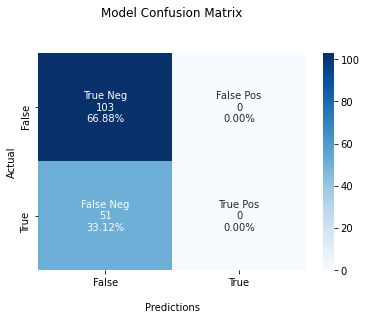

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy:0.6465891062929666


C:\Users\14122\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


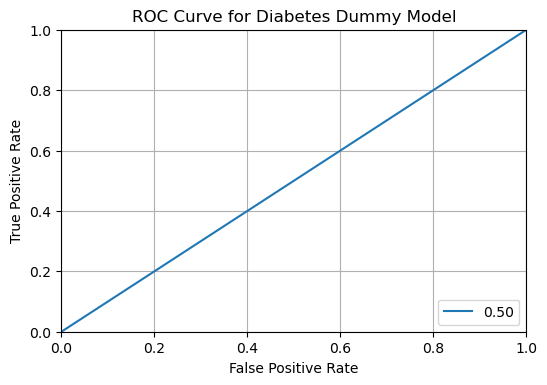

In [36]:
dummy_model = DummyClassifier(strategy="most_frequent")

dummy_model.fit(X_train, y_train)

y_predict = dummy_model.predict(X_test)

confusion_matrix_show(confusion_matrix(y_test, y_predict))

y_train_pred = cross_val_predict(dummy_model, X_train, y_train, cv=10)

accuracy = np.mean(cross_val_score(dummy_model, X_train, y_train, scoring='accuracy', cv=10))

f1 = np.mean(cross_val_score(dummy_model, X_train, y_train, scoring='f1', cv=10))

precision = precision_score(y_train, y_train_pred)

recall = recall_score(y_train, y_train_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy:{accuracy}")


plt.figure(dpi=100)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
plt.plot(fpr,tpr,label = "%.2f" %sklearn.metrics.roc_auc_score(y_test,y_predict))
plt.legend(loc = 'lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve for Diabetes Dummy Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Since our most frequently occuring instance is no diabetes, our dummy model returns absolutely no positive values.
As we can see, that would give us a 0 for precision as well as recall, but it returns a 65% accuracy rate as well as a ROC score of 0.5. It's important that we note these things: a ROC score of 0.5 is a very poor score. The seemingly high accuracy score reveals that accuracy is not a good metric tool for our classification task, so we will disregard it completely and stick with the above mentioned metric tools.

# K Nearest Neighbour Model

Let's take a look at the most base-level KNN Model, to see our improvement.

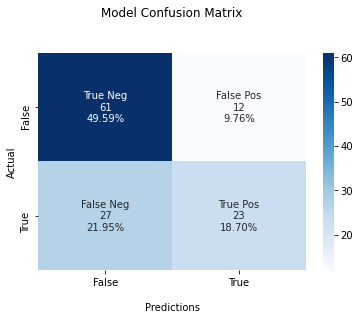

,ROC_AUC,Recall,Precision,F1
0,0.647808,0.46,0.657143,0.541176


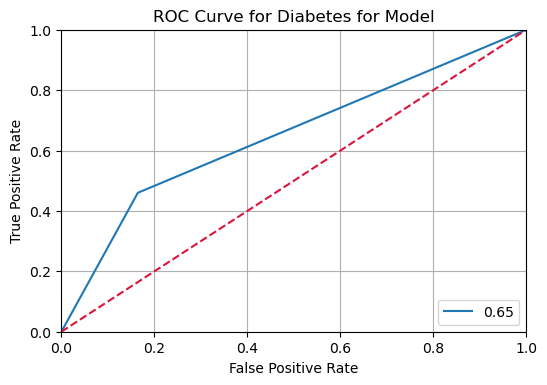

In [25]:
# the most basic knn model

recall_1=[]
precision_1=[]
roc_1=[]
f1_1=[]

knn = KNeighborsClassifier()

knn.fit(X_train2,y_train2)

y_pred = knn.predict(X_test2)

recall_1.append(recall_score(y_test2, y_pred)) 

precision_1.append(precision_score(y_test2, y_pred)) 

roc_1.append(sklearn.metrics.roc_auc_score(y_test2,y_pred))

f1_1.append(fbeta_score(y_test2, y_pred, beta=1))



d_1 = {'ROC_AUC': roc_1, 'Recall': recall_1,'Precision':precision_1,'F1':f1_1}

dfd1 = pd.DataFrame(data=d_1)

confusion_matrix_show(confusion_matrix(y_test2, y_pred))
roc_show(y_test2,y_pred)

dfd1

Let's see how we can improve upon our model. Let's start with finding the best k

In [26]:
table = {}
index = []
AUC =[]
recall=[]
precision=[]
fbeta=[]

for  i in range(1,100):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    
    knn.fit(X_train2,y_train2)
    
    y_pred = knn.predict(X_test2)
    
    index.append(i)
    
    AUC.append(sklearn.metrics.roc_auc_score(y_test2,y_pred))
    
    recall.append(recall_score(y_test2, y_pred))
    
    precision.append(precision_score(y_test2, y_pred))
    
    fbeta.append(fbeta_score(y_test2, y_pred, beta=1))
    
    table.update({'K':index})
    table.update({'ROC_AUC':AUC})
    table.update({'Recall': recall})
    table.update({'Precision': precision})
    table.update({'F-Beta': fbeta})
    
df = pd.DataFrame(table)
df.sort_values('ROC_AUC',ascending=False,inplace=True,ignore_index=True)
df.head(10)

,K,ROC_AUC,Recall,Precision,F-Beta
0,3,0.690959,0.56,0.682927,0.615385
1,7,0.687808,0.54,0.692308,0.606742
2,11,0.671507,0.48,0.705882,0.571429
3,19,0.665205,0.44,0.733333,0.550000
4,9,0.664658,0.48,0.685714,0.564706
5,15,0.661507,0.46,0.696970,0.554217
6,22,0.658904,0.40,0.769231,0.526316
7,17,0.658356,0.44,0.709677,0.543210
8,8,0.658356,0.44,0.709677,0.543210
9,10,0.655205,0.42,0.724138,0.531646


It appears that our best K currently, based on our ROC score, is 3. However, with cross validation we may receieve a different K, and that one we can be more sure of. Let's try it.

In [27]:
recall = []
ind=[]
roc=[]
f1=[]

for  i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X_train_stand,y_train_stand,cv=10,scoring='recall')
    score2=cross_val_score(knn,X_train_stand,y_train_stand,cv=10,scoring='roc_auc')
    score3=cross_val_score(knn,X_train_stand,y_train_stand,cv=10,scoring='f1')
    recall.append(score.mean())
    roc.append(score2.mean())
    f1.append(score3.mean())
    ind.append(i)
d = {'K': ind, 'Recall': recall,'ROC_AUC': roc,'F1':f1}
dfd = pd.DataFrame(data=d)
dfd.sort_values('Recall',ascending=False,inplace=True,ignore_index=True)
dfd.head(10)

,K,Recall,ROC_AUC,F1
0,7,0.570996,0.775141,0.607985
1,9,0.561688,0.790134,0.598629
2,3,0.558009,0.733410,0.564841
3,1,0.548918,0.647247,0.542004
4,11,0.543290,0.796380,0.588827
5,25,0.529654,0.820126,0.607001
6,5,0.529437,0.758941,0.567925
7,15,0.529221,0.815066,0.592980
8,13,0.524892,0.800526,0.585446
9,21,0.524459,0.816729,0.592136


For the purpose of our model, the current best k for knn is 7, to get the highest possible Recall. However, that K is the best K specifically for the current features we have. 
Through feature selection, we may be able to tune our model even further, and in that case, we will need a new K that will fit the new features. So we will have to repeat this process once we select our features. 

To select our features, we will use the sklearn function Select K Best for classification, which returns the best 'k' number of features in our dataset. We will further tweak this by creating another function to find the best 'k' to set the number of features. 

In [28]:
# feature selection
def select_features(X_train, y_train, X_test,i):
    
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_classif, k=i)
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    # transform train input data
    X_train_fs = fs.transform(X_train)
    
    # transform test input data
    X_test_fs = fs.transform(X_test)
        
    return X_train_fs, X_test_fs, fs

def find_best_score(arr,r):
    maxn=-100
    maxI=0
    for i in range(r):
        if(maxn<arr[i]):
            maxn=arr[i]
            maxI=i+1
    return maxn

def find_best(arr,r):
    maxn=-100
    maxI=0
    for i in range(r):
        if(maxn<arr[i]):
            maxn=arr[i]
            maxI=i+1
    return maxI

In [29]:
modelIk=[]
modelIk.append(0)
modelIndex=range(0,17)
for i in range(1,17):
    X_train_fs, X_test_fs, fs = select_features(X_train_stand, y_train, X_test,i)
    modelI=[]
    
    for j in range(1,100):
        knn = KNeighborsClassifier(n_neighbors=j)
        knn.fit(X_train_fs,y_train)

        model_improved = np.mean(cross_val_score(knn, X_train_fs, y_train, scoring='recall', cv=10))
        modelI.append(model_improved)
        #np.seterr(invalid='ignore')
    modelIk.append(find_best_score(modelI,99))

print("done")

done


In [30]:
dfmake = {'K': modelIndex, 'Recall': modelIk}
dfsmall = pd.DataFrame(data=dfmake)
dfsmall.sort_values('Recall',ascending=False,inplace=True,ignore_index=True)
#dfsmall['score'].sort_values(ascending=False)
dfsmall.head(10)

,K,Recall
0,8,0.654762
1,7,0.644372
2,10,0.640260
3,9,0.635498
4,11,0.616883
5,14,0.593939
6,13,0.593939
7,5,0.589610
8,6,0.589610
9,4,0.580952


As we can see the best amount of features to use for our knn model is 8 features.
lets check which features those are.

In [31]:
X_train_fs, X_test_fs, fs = select_features(X_train_stand, y_train_stand, X_test_stand,8)

In [32]:
features_list = [['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'High_BloodPressure',
       'Elderly', 'Thickness_level', 'Weight_Healthy', 'Weight_Obese',
       'Weight_UnderWeight', 'Glucose_Level_high_glucose_levels',
       'Glucose_Level_low_glucose_levels',
       'Glucose_Level_normal_glucose_levels']]

fs.get_support()

array([False,  True, False, False,  True,  True, False,  True, False,
       False, False,  True,  True, False,  True, False,  True])

As we can see the features selected are:
    
- Glucose
- Insulin
- BMI
- Age
- Weight_Healthy
- Weight_Obese
- Glucose_Level_high
- Glucose_Level_normal

Now let's see which k is needed to get to the optimal result for our knn models hyper parameter.

In [34]:
k2 = []
ind=[]
ind=range(1,100)

for  i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X_train_fs,y_train_stand,cv=10,scoring='recall')
    k2.append(score.mean())
d2 = {'K': ind, 'Recall': k2}
dfd2 = pd.DataFrame(data=d2)
dfd2.sort_values('Recall',ascending=False,inplace=True,ignore_index=True)
dfd2.head(10)


,K,Recall
0,9,0.654762
1,11,0.654545
2,13,0.645238
3,7,0.645022
4,5,0.636364
5,25,0.631169
6,15,0.626407
7,27,0.622078
8,23,0.622078
9,29,0.617749


We see here that the k that we need is 9.

To further optimise our model we need to choose a threshold to control how many false positives and false negatives we get.
Our decision on what the threshold should be depends on what you see as more important.For instance for pregnancy tests you'd rather have false positives than false negatives, because the customor would prefer thinking they are pregnant when they aren't than thinking they aren't when they are.

So let's choose the best threshold for the best results.

In [35]:
X_train2_fs, X_test2_fs, y_train2, y_test2 = train_test_split(X_train_fs,y_train_stand, test_size=0.2, random_state=25)

In [37]:
knn_v2 = KNeighborsClassifier(n_neighbors=9)

knn_v2.fit(X_train2_fs,y_train2)

y_scores = knn_v2.predict(X_test2_fs)

prodict_prob_train=knn_v2.predict_proba(X_train2_fs)
print('knn train roc-auc: {}'.format(roc_auc_score(y_train2,prodict_prob_train[:,1])))

prodict_prob_test=knn_v2.predict_proba(X_test2_fs)
print('knn test roc-auc: {}'.format(roc_auc_score(y_test2,prodict_prob_test[:,1])))

preds=[]
preds.append(pd.Series(knn_v2.predict_proba(X_test2_fs)[:,1]))
predictions=pd.concat(preds,axis=1)
print('final prints:{}'.format(roc_auc_score(y_test2,predictions)))

fpr, tpr, thresholds = roc_curve(y_test2, predictions)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_test2, y_scores))

gmeans = (tpr * (1-fpr))**0.5
ix = np.argmax(gmeans)

optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold value is: {optimal_threshold} with score of {gmeans[optimal_idx]}" )

knn train roc-auc: 0.8845826864788942
knn test roc-auc: 0.7905479452054794
final prints:0.7905479452054794
[0.   0.02 0.12 0.22 0.36 0.46 0.64 0.86 0.96 0.98 1.  ]
[0.         0.01369863 0.02739726 0.06849315 0.12328767 0.19178082
 0.24657534 0.32876712 0.50684932 0.68493151 1.        ]
[2.         1.         0.88888889 0.77777778 0.66666667 0.55555556
 0.44444444 0.33333333 0.22222222 0.11111111 0.        ]
0.6341095890410958
Threshold value is: 0.3333333333333333 with score of 0.75977646316045


Now that we found our optimised threshold for our model. Let's apply it and see our results.

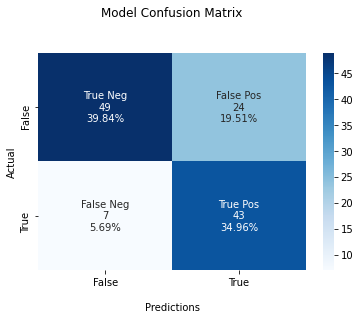

,ROC_AUC,Recall,Precision,F1
0,0.765616,0.86,0.641791,0.735043


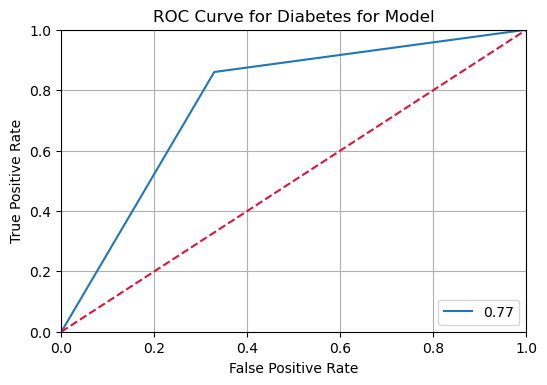

In [38]:
# testing the optimized model:
recall_opt=[]
precision_opt=[]
roc_opt=[]
f1_opt=[]

knn_opt = KNeighborsClassifier(n_neighbors=9)

knn_opt.fit(X_train2_fs,y_train2)

threshold_knn = optimal_threshold

predicted_proba = knn_opt.predict_proba(X_test2_fs)
y_pred_opt = (predicted_proba [:,1] >= threshold_knn).astype('int')

accuracy = accuracy_score(y_test2,y_pred_opt)



#y_pred_opt = knn_opt.predict(X_test2_fs)

recall_opt.append(recall_score(y_test2, y_pred_opt)) 

precision_opt.append(precision_score(y_test2, y_pred_opt)) 

roc_opt.append(sklearn.metrics.roc_auc_score(y_test2,y_pred_opt))

f1_opt.append(fbeta_score(y_test2, y_pred_opt, beta=1))

d_opt = {'ROC_AUC': roc_opt, 'Recall': recall_opt,'Precision':precision_opt,'F1':f1_opt}

df_opt = pd.DataFrame(data=d_opt)

confusion_matrix_show(confusion_matrix(y_test2, y_pred_opt))
roc_show(y_test2,y_pred_opt)

df_opt

As we can see our results are significantly better after applying our better threshold.

# Random Forest Classifier

Let's take a look at the most base-level RFC Model,so we can see our improvement later.

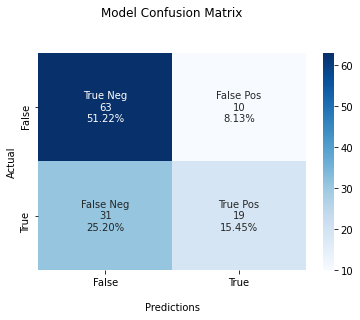

,ROC_AUC,Recall,Precision,F1
0,0.621507,0.38,0.655172,0.481013


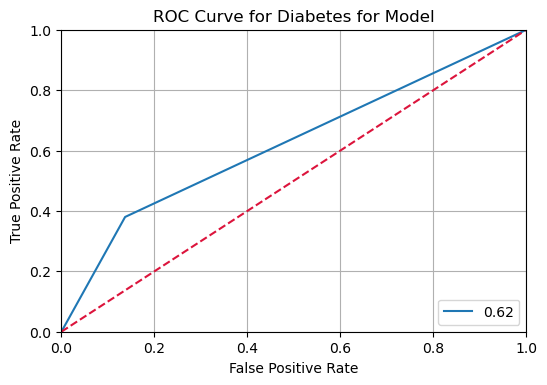

In [39]:
# the most basic model

random_forest = RandomForestClassifier()


random_forest.fit(X_train2,y_train2)

recall_rf1=[]
precision_rf1=[]
roc_rf1=[]
f1_rf1=[]


y_pred_rf1 = random_forest.predict(X_test2)

recall_rf1.append(recall_score(y_test2, y_pred_rf1)) 

precision_rf1.append(precision_score(y_test2, y_pred_rf1)) 

roc_rf1.append(sklearn.metrics.roc_auc_score(y_test2,y_pred_rf1))

f1_rf1.append(fbeta_score(y_test2, y_pred_rf1, beta=1))



d_rf1= {'ROC_AUC': roc_rf1, 'Recall': recall_rf1,'Precision':precision_rf1,'F1':f1_rf1}

dfd_rf1 = pd.DataFrame(data=d_rf1)

confusion_matrix_show(confusion_matrix(y_test2, y_pred_rf1))
roc_show(y_test2,y_pred_rf1)

dfd_rf1

As we can see, it is not performing as well as the optimised knn model. However its better than our dummy model, and has potential for improvement.

Let's try to improve it by first and foremost using our standarized data to see if there are any changes. We will compare the results from the previous results.

In [40]:
random_forest_stand = RandomForestClassifier()

random_forest_stand.fit(X_train_stand,y_train_stand)

# cross val
score= cross_val_score(random_forest_stand,X_train_stand,y_train_stand,cv=10,scoring='recall')
score2= cross_val_score(random_forest_stand,X_train_stand,y_train_stand,cv=10,scoring='roc_auc')
score3= cross_val_score(random_forest_stand,X_train_stand,y_train_stand,cv=10,scoring='f1')
score4= cross_val_score(random_forest_stand,X_train_stand,y_train_stand,cv=10,scoring='precision')


roc_rf1.append(score2.mean())
    
recall_rf1.append(score.mean())
    
precision_rf1.append(score4.mean())
    
f1_rf1.append(score3.mean())

d_rf2= {'ROC_AUC': roc_rf1, 'Recall': recall_rf1,'Precision':precision_rf1,'F1':f1_rf1}

dfd_rf2 = pd.DataFrame(data=d_rf2)

dfd_rf2

,ROC_AUC,Recall,Precision,F1
0,0.621507,0.380000,0.655172,0.481013
1,0.818766,0.588961,0.668068,0.606979


There is a major improvement in the ROC and Recall scores, as well as an improvement in the F1 score, through standarization of the data and cross validation. Therefore, we will use our standarized dataset.

Now we need to use feature selection to see how many and what features are the best for our model.


In [87]:
modelIndex=range(0,17)
modelI2=[]
modelI2.append(0)

rf = RandomForestClassifier()
for i in range(1,17):
    X_train_fs, X_test_fs, fs = select_features(X_train_stand, y_train_stand, X_test_stand,i) 
    rf.fit(X_train_fs,y_train)

    model_improved2 = np.mean(cross_val_score(rf, X_train_fs, y_train, scoring='recall', cv=10))
    
    modelI2.append(model_improved2)    
print("done")

done


In [88]:
dfmake = {'K': modelIndex, 'Recall': modelI2}
dfsmall = pd.DataFrame(data=dfmake)
dfsmall.sort_values('Recall',ascending=False,inplace=True,ignore_index=True)
dfsmall.head()

,K,Recall
0,8,0.616667
1,7,0.612987
2,10,0.603030
3,9,0.602597
4,15,0.593506


As we can see the best amount of features to use for our RFC model is 8 features.
Let's check which features those are.

In [89]:
X_train_fs, X_test_fs, fs = select_features(X_train_stand, y_train_stand, X_test_stand,8)

features_list = [['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'High_BloodPressure',
       'Elderly', 'Thickness_level', 'Weight_Healthy', 'Weight_Obese',
       'Weight_UnderWeight', 'Glucose_Level_high_glucose_levels',
       'Glucose_Level_low_glucose_levels',
       'Glucose_Level_normal_glucose_levels']]

fs.get_support()

array([False,  True, False, False,  True,  True, False,  True, False,
       False, False,  True,  True, False,  True, False,  True])

As we can see the features selected this time are:

- Glucose
- Insulin
- BMI
- Age
- Weight_Healthy
- Weight_Obese
- Glucose_Level_high
- Glucose_Level_normal

Now to get the most optimised results all we need to do is find the best hyper parameters for our models.

In [90]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [91]:
# search across 100 different combinations, and use all availimba_pipelineores
random_forest_cv = RandomForestClassifier()

random_forest_cv.fit(X_train_fs,y_train_stand)

rf_random = RandomizedSearchCV(estimator = random_forest_cv, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1, scoring='recall')
# Fit the random search model
rf_random.fit(X_train_fs, y_train_stand)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='recall', verbose=3)

In [92]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

Now that we found our best hyper parameters we can fit it to our model and see the results.

In [93]:
roc_tuned=[]
recall_tuned=[]
f1_tuned=[]
precision_tuned=[]

rf_tuned = rf_random.best_estimator_

rf_tuned.fit(X_train_fs,y_train_stand)

# cross val
score= cross_val_score(rf_tuned,X_train_fs,y_train_stand,cv=10,scoring='recall')
score2= cross_val_score(rf_tuned,X_train_fs,y_train_stand,cv=10,scoring='roc_auc')
score3= cross_val_score(rf_tuned,X_train_fs,y_train_stand,cv=10,scoring='f1')
score4= cross_val_score(rf_tuned,X_train_fs,y_train_stand,cv=10,scoring='precision')


roc_tuned.append(score2.mean())
    
recall_tuned.append(score.mean())
    
precision_tuned.append(score4.mean())
    
f1_tuned.append(score3.mean())

d_rf3= {'ROC_AUC': roc_tuned, 'Recall': recall_tuned,'Precision':precision_tuned,'F1':f1_tuned}

dfd_rf3 = pd.DataFrame(data=d_rf3)

dfd_rf3

,ROC_AUC,Recall,Precision,F1
0,0.820398,0.616667,0.650758,0.628641


There is a slight improvement in the ROC, Recall, and F1. The final step is to get the best threshold

In [94]:
X_train2_fs, X_test2_fs, y_train2, y_test2 = train_test_split(X_train_fs,y_train_stand, test_size=0.2, random_state=25)

In [95]:
rf_v4 = rf_random.best_estimator_

rf_v4.fit(X_train2_fs,y_train2)

y_scores = rf_v4.predict(X_test2_fs)

prodict_prob_train=rf_v4.predict_proba(X_train2_fs)
print('rf train roc-auc: {}'.format(roc_auc_score(y_train2,prodict_prob_train[:,1])))

prodict_prob_test=rf_v4.predict_proba(X_test2_fs)
print('rf test roc-auc: {}'.format(roc_auc_score(y_test2,prodict_prob_test[:,1])))

preds=[]
preds.append(pd.Series(rf_v4.predict_proba(X_test2_fs)[:,1]))
predictions=pd.concat(preds,axis=1)
print('final prints:{}'.format(roc_auc_score(y_test2,predictions)))

fpr, tpr, thresholds = roc_curve(y_test2, predictions)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_test2, y_scores))

gmeans = (tpr * (1-fpr))**0.5
ix = np.argmax(gmeans)

optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold value is: {optimal_threshold} with score of {gmeans[optimal_idx]}" )

rf train roc-auc: 0.9927552302801803
rf test roc-auc: 0.8057534246575343
final prints:0.8057534246575343
[0.   0.   0.02 0.02 0.12 0.12 0.18 0.18 0.2  0.2  0.26 0.26 0.34 0.34
 0.36 0.36 0.42 0.42 0.6  0.6  0.7  0.7  0.74 0.74 0.78 0.78 0.8  0.8
 0.84 0.84 0.86 0.86 0.88 0.88 0.9  0.9  0.92 0.92 0.96 0.96 0.98 0.98
 1.   1.  ]
[0.         0.01369863 0.01369863 0.02739726 0.02739726 0.04109589
 0.04109589 0.06849315 0.06849315 0.08219178 0.08219178 0.09589041
 0.09589041 0.12328767 0.12328767 0.1369863  0.1369863  0.17808219
 0.17808219 0.19178082 0.19178082 0.20547945 0.20547945 0.21917808
 0.21917808 0.24657534 0.24657534 0.26027397 0.26027397 0.2739726
 0.2739726  0.32876712 0.32876712 0.36986301 0.36986301 0.43835616
 0.43835616 0.60273973 0.60273973 0.61643836 0.61643836 0.79452055
 0.79452055 1.        ]
[1.94965587 0.94965587 0.93925518 0.92220559 0.84231368 0.81053889
 0.72043879 0.68133763 0.66855801 0.64785181 0.61892924 0.61705287
 0.59957677 0.59488165 0.58583095 0.58558074 

Now that we found our optimised threshold for our model lets apply it and see our results.

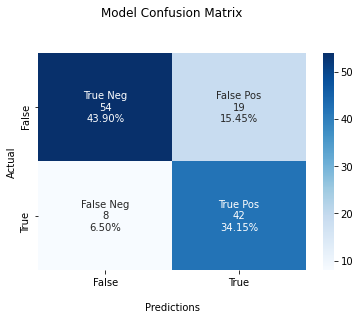

,ROC_AUC,Recall,Precision,F1
0,0.789863,0.84,0.688525,0.756757


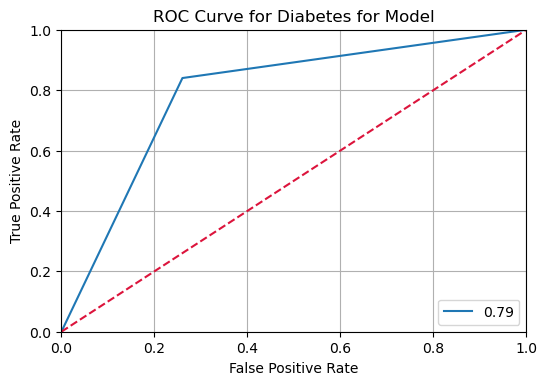

In [96]:
threshold = optimal_threshold

random_forest_opt = rf_random.best_estimator_


random_forest_opt.fit(X_train2_fs,y_train2)

predicted_proba = random_forest_opt.predict_proba(X_test2_fs)
y_pred_opt = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test2, y_pred_opt)


# optimized model

recall_opt=[]
precision_opt=[]
roc_opt=[]
f1_opt=[]



recall_opt.append(recall_score(y_test2, y_pred_opt)) 

precision_opt.append(precision_score(y_test2, y_pred_opt)) 

roc_opt.append(sklearn.metrics.roc_auc_score(y_test2,y_pred_opt))

f1_opt.append(fbeta_score(y_test2, y_pred_opt, beta=1))



d_opt= {'ROC_AUC': roc_opt, 'Recall': recall_opt,'Precision':precision_opt,'F1':f1_opt}

dfd_opt = pd.DataFrame(data=d_opt)

confusion_matrix_show(confusion_matrix(y_test2, y_pred_opt))
roc_show(y_test2,y_pred_opt)

dfd_opt

As we can see after applying the threshold and using our most optimised model we have an astounding improvment(except roc auc)! Way to go!
Additionally, this model has an even more impressive performance than its optimized KNN counterpart, and therefore, we will use it for our final test.

# Testing Our Best Model

After testing two classification models and optimizing them through different methods (scaling, feature selection, hyperparameter tuning), we have chosen the following to be our final model:

The Random Forest Classifier model, with the following features and hyperparameters:

In [97]:
X_train_fs, X_test_fs, fs = select_features(X_train_stand, y_train_stand, X_test_stand,8)

Features Selected:

- Glucose
- Insulin
- BMI
- Age
- Weight_Healthy
- Weight_Obese
- Glucose_Level_high
- Glucose_Level_normal

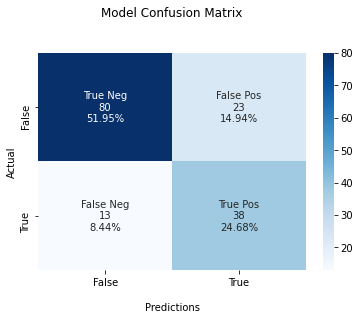

,ROC_AUC,Recall,Precision,F1
0,0.760899,0.745098,0.622951,0.678571


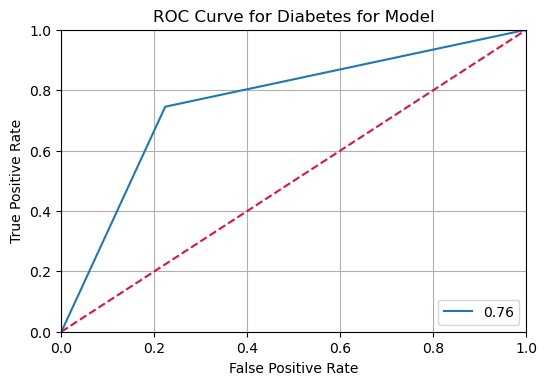

In [98]:
random_forest_opt = rf_random.best_estimator_


random_forest_opt.fit(X_train_fs,y_train)

predicted_proba = random_forest_opt.predict_proba(X_test_fs)
y_pred_opt = (predicted_proba [:,1] >= threshold).astype('int')


# optimized model

recall_opt=[]
precision_opt=[]
roc_opt=[]
f1_opt=[]



recall_opt.append(recall_score(y_test, y_pred_opt)) 

precision_opt.append(precision_score(y_test, y_pred_opt)) 

roc_opt.append(sklearn.metrics.roc_auc_score(y_test,y_pred_opt))

f1_opt.append(fbeta_score(y_test, y_pred_opt, beta=1))



d_opt= {'ROC_AUC': roc_opt, 'Recall': recall_opt,'Precision':precision_opt,'F1':f1_opt}

dfd_opt = pd.DataFrame(data=d_opt)

confusion_matrix_show(confusion_matrix(y_test, y_pred_opt))
roc_show(y_test,y_pred_opt)

dfd_opt

In summary, our best model's performance was able to give us an AUC of ROC score of 0.76, a recall score of 0.75, a precision score of 0.62 and an f1 score of 0.68. All of these scores (albeit the precision score, that has to decrease due to the major increase in the recall score) have shown great improvement. Indeed, we have a solid model that is able to differentiate between instances of diabetes and non-diabetes according to the following features: glucose, glucose levels (high or normal), BMI, insulin, age, and categories of weight (healthy or obese). 